In [1]:
##############################################################################################################
# DESCRIPTION: 
#              
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 600 #10000
hyperparams.BATCH_SIZE = 16
hyperparams.START_NEURONS = 8 # UNET
hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0100_1000"
MODEL_NAME = "0100_1000-64-unet-xxn3"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898 
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248 

#from tensorflow.keras.optimizers import Adam
#hyperparams.OPTIMIZER = Adam(learning_rate=0.0001)
from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)
#from tensorflow.keras.optimizers import RMSprop
#hyperparams.OPTIMIZER = RMSprop(learning_rate = 0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import UnetI as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12144550784241956044
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5722079232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9636651670052812644
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Loss=mean_absolute_error
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 8)    0           conv2d_1[0][0]                   
_____________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = \
                dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

val_noisy_files, val_nitid_files, val_noisy, val_nitid = \
                dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = \
                dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:8738
Nitid files:8738
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2208
Nitid files:2208


In [7]:
##################
# TRAIN MODEL
##################

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Epoch 1/600
547/547 [==============================] - 25s 36ms/step - loss: 0.0919 - val_loss: 0.0286
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-unet-xxn3_checkpoint__weights_01-0.03\assets
Epoch 2/600
547/547 [==============================] - 20s 35ms/step - loss: 0.0310 - val_loss: 0.0250
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-unet-xxn3_checkpoint__weights_02-0.03\assets
Epoch 3/600
547/547 [==============================] - 19s 35ms/step - loss: 0.0279 - val_loss: 0.0232
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-unet-xxn3_checkpoint__weights_03-0.02\assets
Epoch 4/600
547/547 [==============================] - 19s 35ms/step - loss: 0.0268 - val_loss: 0.0250
Epoch 5/600
547/547 [==============================] - 20s 36ms/step - loss: 0.0262 - val_loss: 0.0224
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-unet-xxn3_checkpoint__weights_05-0

Epoch 68/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0195 - val_loss: 0.0211
Epoch 69/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0195 - val_loss: 0.0202
Epoch 70/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0195 - val_loss: 0.0224
Epoch 71/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0194 - val_loss: 0.0208
Epoch 72/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0193 - val_loss: 0.0215
Epoch 73/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0194 - val_loss: 0.0209
Epoch 74/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0194 - val_loss: 0.0199
Epoch 75/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0193 - val_loss: 0.0205
Epoch 76/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0192 - val_loss: 0.0209
Epoch 77/600
547/547 [==============================] - 19s 34ms

Epoch 144/600
547/547 [==============================] - 19s 34ms/step - loss: 0.0171 - val_loss: 0.0200
Epoch 145/600
547/547 [==============================] - 18s 32ms/step - loss: 0.0171 - val_loss: 0.0199
Epoch 146/600
547/547 [==============================] - 18s 33ms/step - loss: 0.0168 - val_loss: 0.0208
Restoring model weights from the end of the best epoch.
Epoch 00146: early stopping
Train size:8738
Valid.size:2208
--- 2811.3689308166504 seconds ---


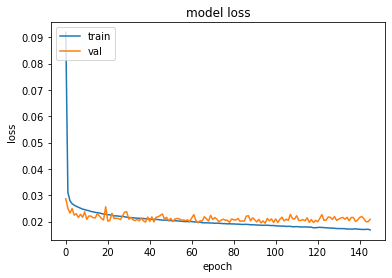

Best Epoch:96


In [8]:
##################
# REPORTS
##################

reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-unet-xxn3\assets


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =2208
Best RMSENZ  =2059 (0.93)
Best MAENZ   =2066 (0.94)
Best PSNR    =2059 (0.93)
Best Accuracy=1960 (0.89)
RMSE-NZ  Pred=0.0229  Noisy=0.0943
MAE-NZ   Pred=0.0194  Noisy=0.0903
PSNR     Pred=20.9 dB Noisy=9.4 dB
Accuracy Pred=0.42    Noisy=0.09
SSM      Pred=0.96    Noisy=0.66
HOG MSE  Pred=0.08    Noisy=0.12


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test/
Noisy files:19
Nitid files:19
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_12_nitid_idx134.tif


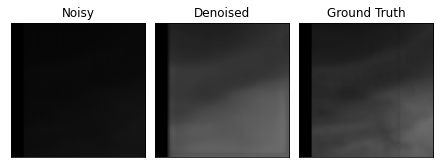

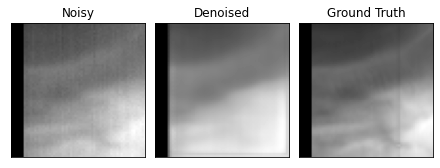

RMSE-NZ  Pred=0.0546  Noisy=0.1722 BEST
MAE-NZ   Pred=0.0483  Noisy=0.1588 BEST
PSNR     Pred=17.7 dB Noisy=7.7 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.31
HOG MSE  Pred=0.05    Noisy=0.04
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_nitid_idx134.tif


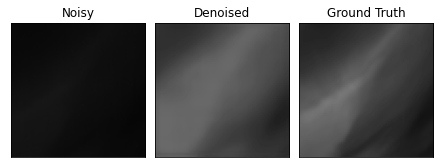

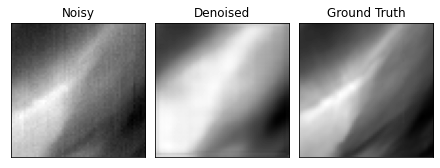

RMSE-NZ  Pred=0.0649  Noisy=0.2105 BEST
MAE-NZ   Pred=0.0600  Noisy=0.1954 BEST
PSNR     Pred=17.2 dB Noisy=6.9 dB BEST
Accuracy Pred=0.04    Noisy=0.00 BEST
SSM      Pred=0.90    Noisy=0.30
HOG MSE  Pred=0.03    Noisy=0.13
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_nitid_idx134.tif


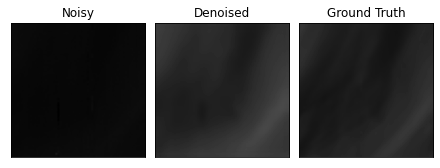

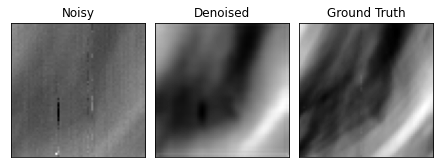

RMSE-NZ  Pred=0.0460  Noisy=0.0994 BEST
MAE-NZ   Pred=0.0434  Noisy=0.0953 BEST
PSNR     Pred=13.7 dB Noisy=7.0 dB BEST
Accuracy Pred=0.01    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.36
HOG MSE  Pred=0.03    Noisy=0.16
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_noisy_idx014.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_nitid_idx017.tif


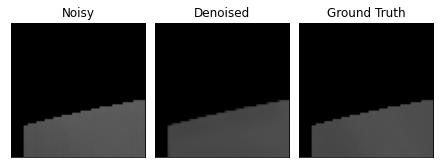

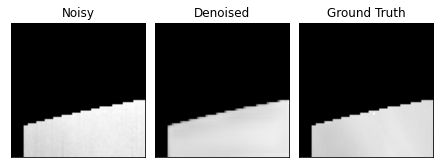

RMSE-NZ  Pred=0.0131  Noisy=0.0388 BEST
MAE-NZ   Pred=0.0053  Noisy=0.0376 BEST
PSNR     Pred=28.4 dB Noisy=19.0 dB BEST
Accuracy Pred=0.80    Noisy=0.00 BEST
SSM      Pred=0.99    Noisy=0.98
HOG MSE  Pred=0.12    Noisy=0.07
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_nitid_idx017.tif


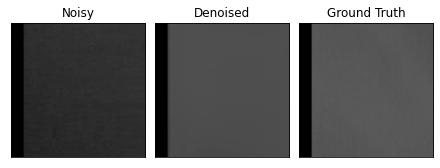

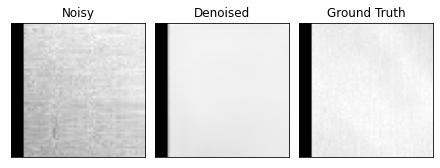

RMSE-NZ  Pred=0.0368  Noisy=0.1632 BEST
MAE-NZ   Pred=0.0334  Noisy=0.1622 BEST
PSNR     Pred=19.8 dB Noisy=6.9 dB BEST
Accuracy Pred=0.10    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.83
HOG MSE  Pred=0.04    Noisy=0.01
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_02_12_nitid_idx134.tif


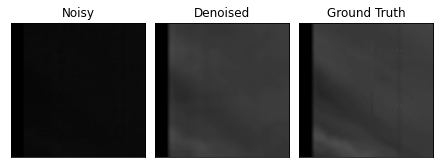

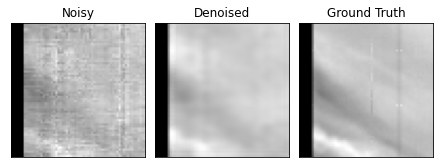

RMSE-NZ  Pred=0.0123  Noisy=0.1870 BEST
MAE-NZ   Pred=0.0098  Noisy=0.1854 BEST
PSNR     Pred=27.8 dB Noisy=4.2 dB BEST
Accuracy Pred=0.55    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.32
HOG MSE  Pred=0.03    Noisy=0.03
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_nitid_idx134.tif


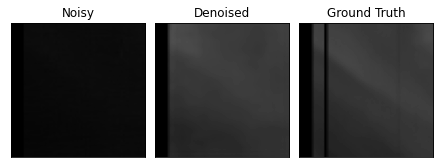

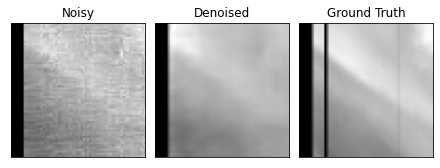

RMSE-NZ  Pred=0.0328  Noisy=0.1704 BEST
MAE-NZ   Pred=0.0143  Noisy=0.1661 BEST
PSNR     Pred=18.9 dB Noisy=4.6 dB BEST
Accuracy Pred=0.58    Noisy=0.00 BEST
SSM      Pred=0.89    Noisy=0.33
HOG MSE  Pred=0.03    Noisy=0.07
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_nitid_idx134.tif


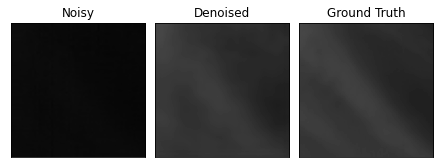

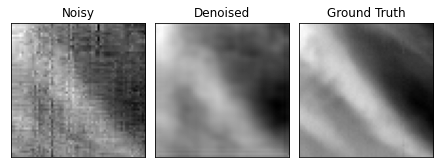

RMSE-NZ  Pred=0.0121  Noisy=0.1649 BEST
MAE-NZ   Pred=0.0097  Noisy=0.1619 BEST
PSNR     Pred=27.3 dB Noisy=4.6 dB BEST
Accuracy Pred=0.59    Noisy=0.00 BEST
SSM      Pred=0.98    Noisy=0.35
HOG MSE  Pred=0.07    Noisy=0.35
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_03_02_10_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_03_02_10_nitid_idx134.tif


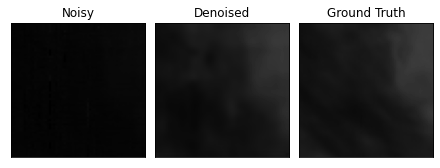

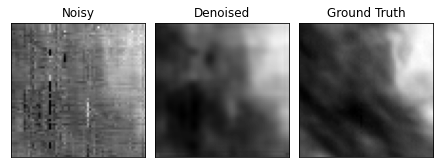

RMSE-NZ  Pred=0.0177  Noisy=0.0964 BEST
MAE-NZ   Pred=0.0146  Noisy=0.0856 BEST
PSNR     Pred=22.6 dB Noisy=7.9 dB BEST
Accuracy Pred=0.39    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.44
HOG MSE  Pred=0.03    Noisy=0.20
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_04_03_14_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_04_03_14_nitid_idx146.tif


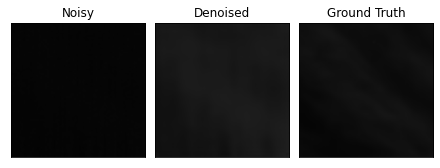

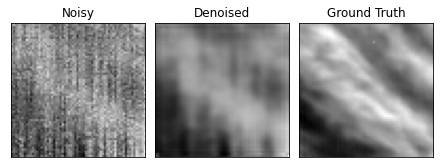

RMSE-NZ  Pred=0.0386  Noisy=0.0368 WORST
MAE-NZ   Pred=0.0378  Noisy=0.0345 WORST
PSNR     Pred=6.9 dB Noisy=7.3 dB WORST
Accuracy Pred=0.00    Noisy=0.05 WORST
SSM      Pred=0.85    Noisy=0.43
HOG MSE  Pred=0.09    Noisy=0.22
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_nitid_idx017.tif


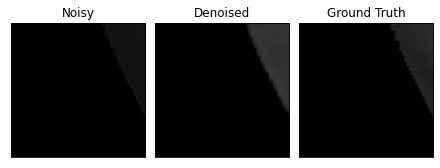

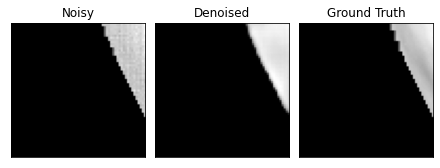

RMSE-NZ  Pred=0.0216  Noisy=0.0366 BEST
MAE-NZ   Pred=0.0074  Noisy=0.0184 BEST
PSNR     Pred=18.6 dB Noisy=14.0 dB BEST
Accuracy Pred=0.87    Noisy=0.74 BEST
SSM      Pred=0.97    Noisy=0.90
HOG MSE  Pred=0.09    Noisy=0.02
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_nitid_idx134.tif


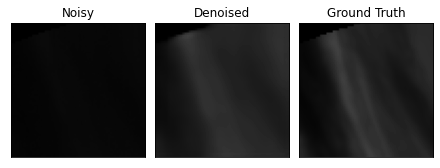

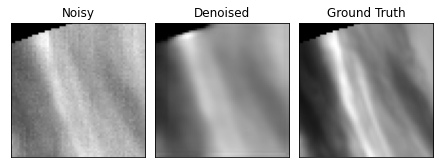

RMSE-NZ  Pred=0.0202  Noisy=0.1089 BEST
MAE-NZ   Pred=0.0165  Noisy=0.0979 BEST
PSNR     Pred=22.0 dB Noisy=7.3 dB BEST
Accuracy Pred=0.32    Noisy=0.01 BEST
SSM      Pred=0.91    Noisy=0.37
HOG MSE  Pred=0.03    Noisy=0.13
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_nitid_idx017.tif


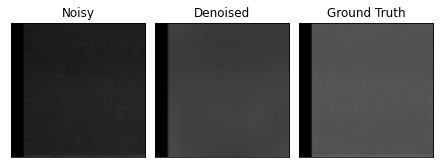

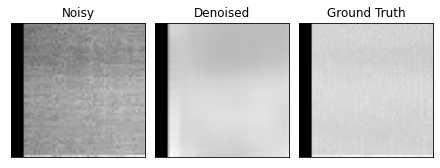

RMSE-NZ  Pred=0.0774  Noisy=0.1952 BEST
MAE-NZ   Pred=0.0722  Noisy=0.1947 BEST
PSNR     Pred=14.1 dB Noisy=6.0 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.77
HOG MSE  Pred=0.03    Noisy=0.02
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_nitid_idx134.tif


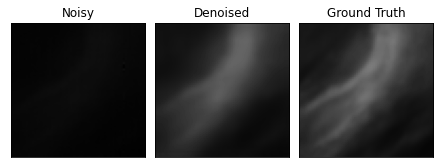

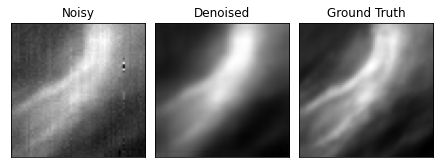

RMSE-NZ  Pred=0.0404  Noisy=0.1931 BEST
MAE-NZ   Pred=0.0349  Noisy=0.1660 BEST
PSNR     Pred=21.6 dB Noisy=8.0 dB BEST
Accuracy Pred=0.06    Noisy=0.00 BEST
SSM      Pred=0.90    Noisy=0.33
HOG MSE  Pred=0.05    Noisy=0.09
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_nitid_idx134.tif


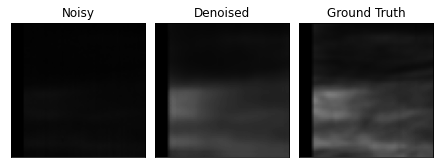

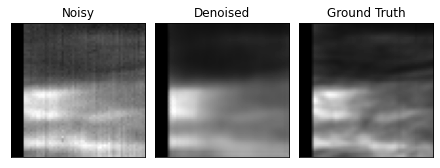

RMSE-NZ  Pred=0.0430  Noisy=0.1742 BEST
MAE-NZ   Pred=0.0323  Noisy=0.1438 BEST
PSNR     Pred=21.2 dB Noisy=9.1 dB BEST
Accuracy Pred=0.21    Noisy=0.00 BEST
SSM      Pred=0.90    Noisy=0.44
HOG MSE  Pred=0.03    Noisy=0.05
******************************************************
Index:15
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_nitid_idx134.tif


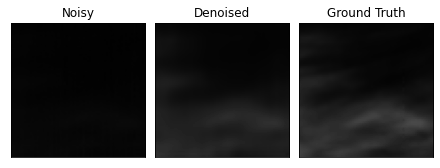

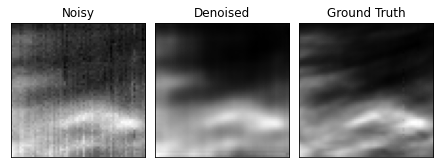

RMSE-NZ  Pred=0.0284  Noisy=0.0979 BEST
MAE-NZ   Pred=0.0201  Noisy=0.0772 BEST
PSNR     Pred=20.1 dB Noisy=9.4 dB BEST
Accuracy Pred=0.45    Noisy=0.04 BEST
SSM      Pred=0.94    Noisy=0.54
HOG MSE  Pred=0.03    Noisy=0.12
******************************************************
Index:16
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_nitid_idx146.tif


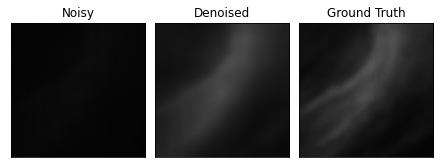

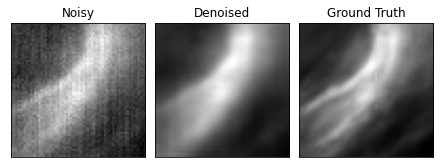

RMSE-NZ  Pred=0.0169  Noisy=0.1221 BEST
MAE-NZ   Pred=0.0138  Noisy=0.1019 BEST
PSNR     Pred=26.0 dB Noisy=8.8 dB BEST
Accuracy Pred=0.41    Noisy=0.02 BEST
SSM      Pred=0.94    Noisy=0.38
HOG MSE  Pred=0.05    Noisy=0.14
******************************************************
Index:17
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_nitid_idx146.tif


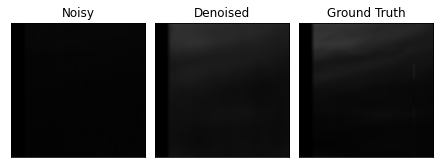

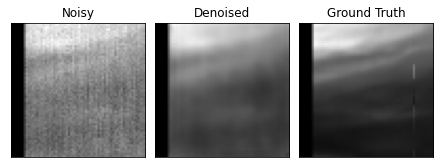

RMSE-NZ  Pred=0.0190  Noisy=0.0710 BEST
MAE-NZ   Pred=0.0159  Noisy=0.0512 BEST
PSNR     Pred=21.4 dB Noisy=10.0 dB BEST
Accuracy Pred=0.33    Noisy=0.21 BEST
SSM      Pred=0.89    Noisy=0.47
HOG MSE  Pred=0.05    Noisy=0.10
******************************************************
Index:18
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_nitid_idx134.tif


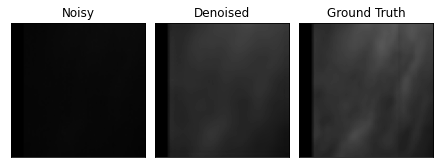

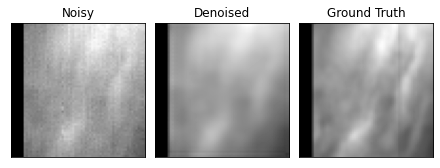

RMSE-NZ  Pred=0.0419  Noisy=0.1835 BEST
MAE-NZ   Pred=0.0371  Noisy=0.1780 BEST
PSNR     Pred=18.3 dB Noisy=5.5 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.34
HOG MSE  Pred=0.03    Noisy=0.03
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )